#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 9:00 AM EST, Thursday, March 10, 2016  
W261-3, Spring 2016  
Week 7 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Some aspects of this notebook don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW7/MIDS-W261-2015-HWK-Week07-Hamlin-Thomas-Baek-Danish.ipynb)


###Useful References:
- **[Original Assignment Instructions](https://www.dropbox.com/s/26ejqhkzqdidzwj/HW7-Questions.txt?dl=0)**


In [ ]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

In [340]:
#Use this line of code to kick off a persistent cluster
!python -m mrjob.tools.emr.create_job_flow '--conf-path' 'mrjob.conf'

creating new scratch bucket mrjob-95d658da5deb24af
using s3://mrjob-95d658da5deb24af/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/no_script.nicholashamlin.20160310.051638.844663
writing master bootstrap script to /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/no_script.nicholashamlin.20160310.051638.844663/b.py
creating S3 bucket 'mrjob-95d658da5deb24af' to use as scratch space
Copying non-input files into s3://mrjob-95d658da5deb24af/tmp/no_script.nicholashamlin.20160310.051638.844663/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-2MM2A2KMPDLBH
j-2MM2A2KMPDLBH


## HW 7.0

### HW 7.0 - Problem Statement
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

### HW 7.0 - MR job definition
For brevity, we've combined the initialization step and the main job into a single unit of code.  During the first pass, we check to make sure each node has been properly initialized and, if not, initialize it.  

In [337]:
%%writefile MRbfs.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
# from mrjob.emr import EMRJobRunner
# from boto.s3.key import Key
import re
import ast

WORD_RE = re.compile(r"[\w']+")
 
class MRbfs(MRJob):

        
    def configure_options(self):
        super(MRbfs, self).configure_options()
        self.add_passthrough_option('--start', default='1', type=str)
        self.add_passthrough_option('--end', default='4', type=str)
        self.add_passthrough_option('--statuspath', default='', type=str)
        self.add_passthrough_option('--iteration', default='1', type=str)
        self.add_passthrough_option('--jobtype', default='local', type=str)

        
    def mapper(self, node, line):
        if self.options.iteration=='1':
            line = line.strip('\n')
            data = line.split("\t")
            status = 'U' #everything is unvisited initially

            # This is the first inialization (from original graph file)
            # there are only 2 elements, the node and adjacency list
            if(len(data) == 2): 
                nid = data[0]
                N = ast.literal_eval(data[1])

                # if our node is the start node , initialize the start
                # distance at source = 0.0
                if nid == self.options.start:
                    ds = 0.0
                    status = 'V'
                    path=[nid]
                else: 
                    # if this is not the start node, intialize distance to inf and path to empty list
                    ds = float("inf")
                    path=[]

                # yield the root node , (distance, graph structure, status, "Visited", and path (as a list))
                # we need this to eventually for next iteration..
                yield  nid, (ds, N, status,path)

                # nor each of the nodes in the adjacency list, 
                # we expand frontier with starting distance.
                for m,d in N.iteritems():
                    #new distance is going to be from root node  + dist              
                    newdist = d+ds
                    new_path=path[:]
                    new_path.append(m)
                    #not sure if this is needed really..just 
                    #marking this single node , dist as in the Q.
                    if newdist < float("inf"):
                        status = 'Q'

                    yield m, (newdist, None, status,new_path)
                    #print m, (newdist, None, status,new_path)
                
        # from Iteration 1 onwards we'll land here...more data items to track
        else:# len(data) == 5:
            if self.options.jobtype=='local':
                inf=float("inf") #THIS IS A TERRIBLE HACKJOB that lets us deal with string/inf eval weirdness
                line = line.strip('\n')
                nid,data=eval(line)
            
            if self.options.jobtype=='emr':
                Infinity=float('inf') #SEE HACKJOB ABOVE
                line = line.strip('\n')
                nid,data=line.split('\t')
                nid=eval(nid)
                data=eval(data)
            
            
            dist=data[0]
            N = data[1] # adjacency list - graph to use for next iter
            status = data[2] #status - U, Q, V
            path=data[3] #list of previously visited nodes
            
              
            #If a node is in the frontier, expand it
            if status=='Q':
                yield  nid, (dist, N, 'V',path)
                #print  nid, (dist, N, 'V',path)
                for m,d in N.iteritems():
                    newdist=d+dist
                    new_path=path[:]
                    new_path.append(m)

                    yield m, (newdist, None, 'Q', new_path)
                    #print m, (newdist, None, 'Q', new_path)
            
            #If it's not in the frontier, pass it through unchanged
            else:        
                yield  nid, (dist, N, status,path)
                #print  nid, (dist, N, status,path)
                    
                    
    def reducer_init(self):
        self.finished=0
        self.shortest_path=[]
        self.min_dist=0
            
    def reducer(self, node, distances):
        adjList = {} #adjacency list - to be compiled below
        sdist = float("inf") #this is the shortest distance we've seen to the node so far
        stati = [] #list of all statuses we've encountered for this node
        spath=[] #shortest path we've found to the node so far
        #node=eval(node)
        for dist in distances:
            node_dist,list_of_links,temp_status,path=dist[:]

            # Extract the original graph structure from the node that has it
            if list_of_links:
                adjList = list_of_links
            
            stati.append(temp_status)
            
            #If we find a record of a visited node, we can move on
            if temp_status == 'V':
                sdist=node_dist
                spath = path
                break
                       
            # If we find a shorter distance to a node, update our knowledge of it
            if node_dist < sdist:
                sdist = node_dist
                spath=path
                if node not in spath:
                    spath.append(node)
            

        if 'V' in stati:
            status='V'
            if node==self.options.end :
                self.shortest_path=spath
                self.finished=1
                self.min_dist=sdist
        elif 'Q' in stati:
            status='Q'
        else:
            status='U'
            
        yield node, (sdist, adjList, status, spath)
        #print node, (sdist, adjList, status, spath)        
        
    def steps(self):
        return [MRStep( #mapper_init=self.mapper_init, 
                        mapper=self.mapper
                        ,reducer_init=self.reducer_init
                        ,reducer=self.reducer
                      )]
    
if __name__ == '__main__':
    MRbfs.run()

Overwriting MRbfs.py


### HW 7.0 - Undirected Toy Test

In [349]:
%%writefile testgraph.txt
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting testgraph.txt


In [351]:
## HW7 - Undirected Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}


#### TEST VERSION #####
input_dir_prefix='testgraph'
start_node='1'
end_node='4'

#### NLTK VERSION #####
# input_dir_prefix='synNet'
# start_node='7827'
# end_node='536'


#### RUN THE JOBS #####
while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRbfs(args=[input_directory, 
                         #'--file=start_end.txt',
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        #'--statuspath',status_path,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True 
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
DONE
Shortest path from 1 to 4 is 2 steps long:
The path is:  ['1', '2', '4']


### HW 7.0 - Directed Toy Test

In [41]:
%%writefile testgraph.txt
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting testgraph.txt


In [336]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}


#### TEST VERSION #####
input_dir_prefix='testgraph'
start_node='1'
end_node='5'

#### NLTK VERSION #####
# input_dir_prefix='synNet'
# start_node='7827'
# end_node='536'


#### RUN THE JOBS #####
while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRbfs(args=[input_directory, 
                         #'--file=start_end.txt',
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        #'--statuspath',status_path,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",output
                    stop=True 
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 1 to 5 is 3 steps long:
The path is:  ['1', '2', '4', '5']


##HW7.1 

### HW 7.1 Problem Statement

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [12]:
%%writefile mrexplorenltk.py

from mrjob.job import MRJob
from mrjob.job import MRStep
import csv
import heapq
from operator import itemgetter
import re
import ast

class mrexplorenltk(MRJob):
    custom_jobconf = None
    def __init__(self, *args, **kwargs):
        super(mrexplorenltk, self).__init__(*args, **kwargs)
        self.node_count = 0
        self.link_count = 0
            
    def mapper(self, _, line):
        line = line.strip('\n')
        data = line.split("\t")
        nid = data[0]
        N = ast.literal_eval(data[1])
        node_degree = len(N)
        self.node_count += 1
        self.link_count += node_degree
        yield node_degree, 1
     
    def mapper_final(self):
        yield -1, self.node_count
        yield -2, self.link_count
        
    def combiner(self, item, counts):
        yield item, sum(counts)
        
    def reducer(self, item, counts):
        yield item, sum(counts)
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,mapper_final = self.mapper_final
                    ,combiner=self.combiner
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    mrexplorenltk.run()

Writing mrexplorenltk.py


Total NodeCount = 8271
Total LinkCount = 61134


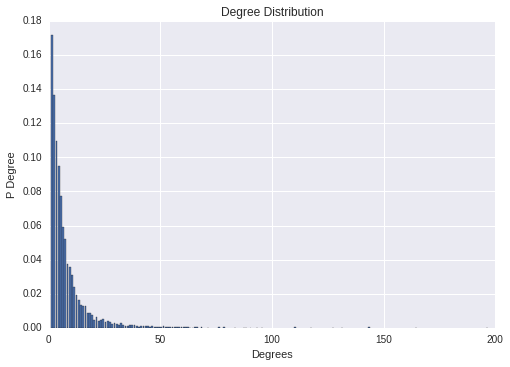

In [8]:
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltk import mrexplorenltk
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(color_codes=True)

deg_dist = []
nodecount = 0
linkcount = 0
mr_job = mrexplorenltk(args=['synNet.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    count = 0
    for line in runner.stream_output():
            item,count =  mr_job.parse_output_line(line)
            #print mr_job.parse_output_line(line)
            if item == -1:
                nodecount = count
            elif item == -2:
                linkcount = count
            else:
                deg_dist.append([item, count/nodecount])

print "Total NodeCount = {}".format(nodecount)   
print "Total LinkCount = {}".format(linkcount)   
deg = np.array(deg_dist)

x = deg[:, 0]   
y = deg[:, 1] 
plt.bar(x,y)
plt.xlabel('Degrees')
plt.ylabel('P Degree')
plt.title('Degree Distribution')
plt.show()

                

As we'd expect, the distribution of degree does follow a power law; there are a handful of pages that are widely linked and lots of pages that have very few links

##HW7.2

### HW 7.2 Problem Statement

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

### HW 7.2 Implementation

In [339]:
## HW7 - NLTK Example, running locally 
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}


#### TEST VERSION #####
# input_dir_prefix='testgraph'
# start_node='1'
# end_node='5'

#### NLTK VERSION #####
input_dir_prefix='synNet'
start_node='7827'
end_node='536'


#### RUN THE JOBS #####
while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRbfs(args=[input_directory, 
                         #'--file=start_end.txt',
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        #'--statuspath',status_path,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 7827 to 536 is 3 steps long:
The path is:  ['7827', '1426', '1668', '536']


In [344]:
# NLTK example, running in EMR
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division

iterate = 1
stop = False

#PUT CLUSTER HERE!!!!!
cluster='j-2MM2A2KMPDLBH'

#### TEST VERSION #####
# input_dir_prefix='testgraph'
# start_node='1'
# end_node='5'

#### NLTK VERSION #####
input_dir_prefix='synNet'
start_node='7827'
end_node='536'

#### RUN THE JOBS #####
while(not stop and iterate <= 10):
    
    #Don't care about this for EMR, since it's defined in the job itself
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
    else:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRbfs(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])

 
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            #print nid, status, path
            if nid==end_node and status=='V':
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                print "The path is: ",path
                stop=True
            if nid==end_node:
                break
            
        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 7827 to 536 is 3 steps long:
The path is:  ['7827', '1426', '1688', '536']


##HW7.3 

### HW 7.3 Problem Statement
Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

In [ ]:
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltk import mrexplorenltk
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(color_codes=True)

#PUT CLUSTER HERE!!!!!
cluster='j-3AH5RMM6FM1X7'

deg_dist = []
nodecount = 0
linkcount = 0
mr_job = mrexplorenltk(args=['synNet.txt'])
mr_job = mrexplorenltk(args=['-r', 
                     'emr',
                     's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt',
                     '--no-strict-protocols',
                     '--output-dir','s3://hamlin-mids-261/WikiEDAOutput'
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                     '--max-hours-idle', '1',
                     '--num-ec2-instances', '4',
                     '--ec2-instance-type', 'm3.xlarge',
                    ])



with mr_job.make_runner() as runner:
    runner.run()
    count = 0
    for line in runner.stream_output():
            item,count =  mr_job.parse_output_line(line)
            #print mr_job.parse_output_line(line)
            if item == -1:
                nodecount = count
            elif item == -2:
                linkcount = count
            else:
                deg_dist.append([item, count/nodecount])

print "Total NodeCount = {}".format(nodecount)   
print "Total LinkCount = {}".format(linkcount)   
deg = np.array(deg_dist)

x = deg[:, 0]   
y = deg[:, 1] 
plt.bar(x,y)
plt.xlabel('Degrees')
plt.ylabel('P Degree')
plt.title('Degree Distribution')
plt.show()

                

Unfortunately our implementation in 7.1 did not scale particularly well, and kept crashing our notebook.  We suspect this may be occurring for two reasons.  The first might be a potential timeout issue in the transfer of data between the original s3 bucket, our EMR cluster, and the notebook.  The other might be an issue with the plotting libraries we've chosen becoming overwhelmed with the scale of the data we're trying to display.  The plots in 7.1 didn't generate particularly quickly, even on the NLTK dataset, which is why we're suspicious of this as a potential pitfall. Given the struture of our code and the fact that 

That said, intuitively we'd expect the general shape of the plot to look similar to what we saw in 7.1, but an even more extreme power law curve.  This is because we're dramatically increasing the size of the data, which means that the most linked pages will have even more links and there will be fewer of them relative to the rest of the population.

##HW 7.4

### HW 7.4 - Problem Statement

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

### HW 7.4 - Running the directed toy example on EMR

In [326]:
# HW 7.4 - Directed toy example with FULL output, running on EMR
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                              
iterate = 1
stop = False

#PUT CLUSTER HERE!!!!!
cluster='j-3AH5RMM6FM1X7'

#### TEST VERSION #####
input_dir_prefix='testgraph'
start_node='1'
end_node='5'

#### NLTK VERSION #####
# input_dir_prefix='synNet'
# start_node='7827'
# end_node='536'

#### RUN THE JOBS #####
while(not stop and iterate <= 10):
    
    if iterate==1:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
    else:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRbfs(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            print nid, status, path
            if nid==end_node and status=='V':
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                print "The path is: ",path
                stop=True 
        print ""
            
        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
1 V ['1']
2 Q ['1', '2']
3 U []
4 U []
5 U []
6 Q ['1', '6']

Iteration : 2
1 V ['1']
2 V ['1', '2']
3 Q ['1', '2', '3']
4 Q ['1', '2', '4']
5 U []
6 V ['1', '6']

Iteration : 3
1 V ['1']
2 V ['1', '2']
3 V ['1', '2', '3']
4 Q ['1', '2', '4']
5 Q ['1', '2', '4', '5']
6 V ['1', '6']

Iteration : 4
1 V ['1']
2 Q ['1', '2']
3 V ['1', '2', '3']
4 V ['1', '2', '4']
5 Q ['1', '2', '4', '5']
6 V ['1', '6']

Iteration : 5
1 V ['1']
2 Q ['1', '2']
3 Q ['1', '2', '3']
4 Q ['1', '2', '4']
5 V ['1', '2', '4', '5']
DONE
Shortest path from 1 to 5 is 3 steps long:
The path is:  ['1', '2', '4', '5']
6 V ['1', '6']



Having confirmed that this works in the cloud, now let's run it on the entire dataset

### HW 7.4  - Full-scale Impelementation

In [348]:
# Real-deal Wikipedia data, running in EMR
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division

iterate = 1
stop = False

#PUT CLUSTER HERE!!!!!
cluster='j-2MM2A2KMPDLBH'

#### TEST VERSION #####
# input_dir_prefix='testgraph'
# start_node='1'
# end_node='5'

#### NLTK VERSION #####
# input_dir_prefix='synNet'
# start_node='7827'
# end_node='536'

#### WIKIPEDIA VERSION #####
input_dir_prefix='wiki'
start_node='6176135'
end_node='13466359'


#### RUN THE JOBS #####
while(not stop and iterate <= 10):
    
    if iterate==1:
        input_directory='s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'
    else:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRbfs(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         '--pool-emr-job-flows',
                         '--max-hours-idle', '1',
                         '--num-ec2-instances', '4',
                         '--ec2-instance-type', 'm3.xlarge',
                         #'--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])

 
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            #print nid, status, path
            if nid==end_node and status=='V':
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                print "The path is: ",path
                stop=True
            if nid==end_node:
                break
            
        #just in case this thing does not stop..
        iterate += 1   


ERROR:boto:403 Forbidden
ERROR:boto:<ErrorResponse xmlns="https://iam.amazonaws.com/doc/2010-05-08/">
  <Error>
    <Type>Sender</Type>
    <Code>AccessDenied</Code>
    <Message>User: arn:aws:iam::808762113437:user/w261 is not authorized to perform: iam:ListInstanceProfiles on resource: arn:aws:iam::808762113437:instance-profile/</Message>
  </Error>
  <RequestId>d15db13e-e692-11e5-bef8-c134bc7b96a8</RequestId>
</ErrorResponse>

ERROR:boto:403 Forbidden
ERROR:boto:<ErrorResponse xmlns="https://iam.amazonaws.com/doc/2010-05-08/">
  <Error>
    <Type>Sender</Type>
    <Code>AccessDenied</Code>
    <Message>User: arn:aws:iam::808762113437:user/w261 is not authorized to perform: iam:ListAttachedRolePolicies on resource: role EMR_DefaultRole</Message>
  </Error>
  <RequestId>d179c4cf-e692-11e5-a006-c9fd821f768d</RequestId>
</ErrorResponse>



Iteration : 1
Iteration : 2


Iteration : 3
DONE
Shortest path from 6176135 to 13466359 is 2 steps long:
The path is:  ['6176135', '11607791', '13466359']


Sure enough, we find only two steps are required to traverse from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359).  One of the big performance hits we noticed (which matches what we saw in 7.3) is the need to stream data from the S3 bucket on the west coast to our EMR cluster on the east coast.  In hindsight, even though we're running this notebook and calling the jobs from the east, the inertia of the data may be large enough to make it worth the additional trouble of setting up the cluster as close to the data as possible.

##HW 7.5

### HW 7.5 Problem Statement
Suppose you wanted to find the largest network distance from a single source,i.e., a node that is the furthest (but still reachable) from a single source. How would you implement this task? How is this different from finding the shortest path graph distances? Is this task more difficult to implement than the shortest path distance? As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

### HW 7.5 Response
We'd find the largest path using a similar, but not exactly the same, approach that we're using here to find the shortest path.  The key difference is that we know in advance that we'll need to thoroughly traverse the entire graph to know that we've found the longest path.  In our shortest path implementation, we stop when we've found the shortest path to the node we're interested in.  This meant that the task isn't necessarily more "difficult" from a logical perspective, but it may be more computationally intensive as it would likely require more iterations to arrive at a conclusion.  Since we know we'll need to run several more iterations (and can't take advantage of the "six-degrees-of-separation" effect that we can when we look for the shortest path), optimizing both our mapreduce implementation and our cluster infrastructure for rapid turnover is even more important when searching for the longest path.  It shouldn't matter whether we use a depth first search or a breadth first search, since we'll still need to visit every node regardless.

##End of Submission